In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         pass
#         #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [89]:
pip install warpctc_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.1 MB/s eta 0:00:0000:0100:01
Discarding https://files.pythonhosted.org/packages/eb/dc/171aaf41b6b71ea7e472fa873aa469138dc98ce1c234d033dc6863e43a76/warpctc_pytorch-0.2.1%2Btorch16.cuda92-cp37-cp37m-manylinux1_x86_64.whl#sha256=255e7d78d197515767bcfd1d3c8eb2fd4f896bae45d30814aa2ce29563ee560f (from https://pypi.org/simple/warpctc-pytorch/): Requested warpctc_pytorch from https://files.pythonhosted.org/packages/eb/dc/171aaf41b6b71ea7e472fa873aa469138dc98ce1c234d033dc6863e43a76/warpctc_pytorch-0.2.1%2Btorch16.cuda92-cp37-cp37m-manylinux1_x86_64.whl#sha256=255e7d78d197515767bcfd1d3c8eb2fd4f896bae45d30814aa2ce29563ee560f has inconsistent version: filename has '0.2.1+torch16.cuda92', but metadata has '0.2.1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.4 MB/s eta 0:00:00a 0:00:01m
Discarding https://files.pythonhosted.org/packages/f6/18/0e90dea56109558adc2be6ca4e44ec2e973705e8f65997a9c96cd275ef21/warpctc_pytorch-0.2.1%2B

In [3]:
import glob

import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn as nn
from torchvision import transforms

# Подготовка данных

(32, 76, 3)


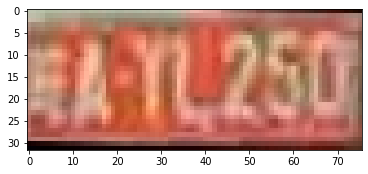

In [4]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/kaggle/input/ccpd2019dl1/CCPD2019-dl1/train/00205459770115-皖AYL250.jpg')
print(img.shape)
plt.imshow(img)

In [5]:
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'
device = torch.device(dev)

In [6]:
def get_label(s):
    return s.split('/')[-1].split('-')[-1].split('.')[0]

In [28]:
class CCPDDataset(torch.utils.data.Dataset):   
    def __init__(self, filenames):
        
        self.transform = transforms.Compose(
            [
                transforms.Resize((32,100)),
                transforms.Grayscale(),
                transforms.ToTensor()
            ]
        )
        
        self.filenames = filenames
        self.y = np.array(
            [get_label(filename) for filename in self.filenames]
        )

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        
        img_name = self.filenames[index]
        img = Image.open(img_name)
        img = self.transform(img)
        #img = cv2.cvtColor(img_name, cv2.COLOR_BGR2GRAY)
        
        target = self.y[index]
        
        return img, target

In [29]:
filenames = glob.glob('/kaggle/input/ccpd2019dl1/CCPD2019-dl1/train/*')

trainset = torch.utils.data.Subset(filenames, list(range(0, len(filenames), 6)))

train_dataset = CCPDDataset(trainset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [30]:
filenames = glob.glob('/kaggle/input/ccpd2019dl1/CCPD2019-dl1/test/*')

testset = torch.utils.data.Subset(filenames, list(range(0, len(filenames), 6)))

test_dataset = CCPDDataset(testset)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Создание и обучение модели

In [79]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)
        return output

In [11]:
all_signs = [train_dataset[i][-1] for i in range(len(train_dataset))]

In [12]:
classes = list(set(''.join(all_signs)))
num_classes = len(classes) + 1

In [22]:
num_classes

64

In [80]:
nh = 256
imgH = 32
imgW = 100
nc = 1
batchSize = 64

crnn = CRNN(imgH, nc, num_classes, nh).to(device)
print(crnn)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.

In [14]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [66]:
from random import randint
import pandas as pd
import requests, zipfile
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
import os

def download_data():
    if 'train_FD004.txt' not in os.listdir('data'):
        print('Downloading Data...')
        # Download the data
        r = requests.get("https://ti.arc.nasa.gov/c/6/", stream=True)
        z = zipfile.ZipFile(StringIO.StringIO(r.content))
        z.extractall('data')
    else:
        print('Using previously downloaded data')
    
def load_data(data_path):   
    operational_settings = ['operational_setting_{}'.format(i + 1) for i in range (3)]
    sensor_columns = ['sensor_measurement_{}'.format(i + 1) for i in range(26)]
    cols = ['engine_no', 'time_in_cycles'] + operational_settings + sensor_columns
    data = pd.read_csv(data_path, sep=' ', header=None, names=cols)
    data = data.drop(cols[-5:], axis=1)
    data['index'] = data.index
    data.index = data['index']
    data['time'] = pd.date_range('1/1/2000', periods=data.shape[0], freq='600s')
    print('Loaded data with:\n{} Recordings\n{} Engines'.format(
        data.shape[0], len(data['engine_no'].unique())))
    print('21 Sensor Measurements\n3 Operational Settings')
    return data

def new_labels(data, labels):
    ct_ids = []
    ct_times = []
    ct_labels = []
    data = data.copy()
    data['RUL'] = labels
    gb = data.groupby(['engine_no'])
    for engine_no_df in gb:
        instances = engine_no_df[1].shape[0]
        r = randint(5, instances - 1)
        ct_ids.append(engine_no_df[1].iloc[r,:]['engine_no'])
        ct_times.append(engine_no_df[1].iloc[r,:]['time'])
        ct_labels.append(engine_no_df[1].iloc[r,:]['RUL'])
    ct = pd.DataFrame({'engine_no': ct_ids,
                       'cutoff_time': ct_times,
                       'RUL': ct_labels})
    ct = ct[['engine_no', 'cutoff_time', 'RUL']]
    ct.index = ct['engine_no']
    ct.index = ct.index.rename('index')
    return ct

def make_cutoff_times(data):
    gb = data.groupby(['engine_no'])
    labels = []


    for engine_no_df in gb:
        instances = engine_no_df[1].shape[0]
        label = [instances - i - 1 for i in range(instances)]
        labels += label
    
    return new_labels(data, labels)

def feature_importances(X, reg, feats=5):
    feature_imps = [(imp, X.columns[i]) 
                    for i, imp in enumerate(reg.feature_importances_)]
    feature_imps.sort()
    feature_imps.reverse()
    for i, f in enumerate(feature_imps[0:feats]):
        print('{}: {} [{:.3f}]'.format(i + 1, f[1], f[0]))
    print('-----\n')
    return [f[1] for f in feature_imps[:feats]]

In [59]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import collections


class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts


class averager(object):
    """Compute average for `torch.Variable` and `torch.Tensor`. """

    def __init__(self):
        self.reset()

    def add(self, v):
        if isinstance(v, Variable):
            count = v.data.numel()
            v = v.data.sum()
        elif isinstance(v, torch.Tensor):
            count = v.numel()
            v = v.sum()

        self.n_count += count
        self.sum += v

    def reset(self):
        self.n_count = 0
        self.sum = 0

    def val(self):
        res = 0
        if self.n_count != 0:
            res = self.sum / float(self.n_count)
        return res

In [15]:
import utils
from torch.autograd import Variable
from torch.nn import CTCLoss

In [75]:
loss_avg = averager()

In [81]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=0.01)
criterion = CTCLoss(reduction='sum',zero_infinity=True)

In [17]:
image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)
length = torch.IntTensor(batchSize)

In [58]:
image = Variable(image)
text = Variable(text)
length = Variable(length)

In [61]:
alphabet = ''.join(classes)

In [62]:
converter = strLabelConverter(alphabet)

In [87]:
def val(net, dataset, criterion, max_iter=100):
    print('Start val')

    for p in crnn.parameters():
        p.requires_grad = False

    net.eval()
    data_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size = 64)
    val_iter = iter(data_loader)

    i = 0
    n_correct = 0
    loss_avg = averager()

    max_iter = min(max_iter, len(data_loader))
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        image = cpu_images.to(device)
        
        t, l = converter.encode(cpu_texts)
        text = t
        length = l

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)

        _, preds = preds.max(2)
        preds = preds.squeeze(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target in zip(sim_preds, cpu_texts):
            if pred == target.lower():
                n_correct += 1

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:10]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * 64)
    print('Test loss: %f, accuray: %f' % (loss_avg.val(), accuracy))

In [88]:
def trainBatch(net, criterion, optimizer):
    data = train_iter.next()
    cpu_images, cpu_texts = data
    batch_size = cpu_images.size(0)
    image = cpu_images.to(device)
    
    t, l = converter.encode(cpu_texts)
    
    text = t
    length = l

    preds = crnn(image)
    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    
    cost = criterion(preds, text, preds_size, length) / batch_size
    crnn.zero_grad()
    cost.backward()
    optimizer.step()
    return cost

In [91]:
nepoch = 25

for epoch in range(nepoch):
    train_iter = iter(train_loader)
    i = 0
    while i < len(train_loader):
        for p in crnn.parameters():
            p.requires_grad = True
        crnn.train()

        cost = trainBatch(crnn, criterion, optimizer)
        loss_avg.add(cost)
        i += 1

        if i % 300 == 0:
            print('[%d/%d][%d/%d] Loss: %f' %
                  (epoch, nepoch, i, len(train_loader), loss_avg.val()))
            loss_avg.reset()

#         if i % 300 == 0:
#             val(crnn, test_dataset, criterion)

[0/25][300/521] Loss: 20.690195
[1/25][300/521] Loss: 20.576706
[2/25][300/521] Loss: 20.504480
[3/25][300/521] Loss: 20.375568
[4/25][300/521] Loss: 20.189753
[5/25][300/521] Loss: 19.964527
[6/25][300/521] Loss: 19.765747
[7/25][300/521] Loss: 19.600004
[8/25][300/521] Loss: 19.408484
[9/25][300/521] Loss: 19.339788
[10/25][300/521] Loss: 19.240191
[11/25][300/521] Loss: 19.178154
[12/25][300/521] Loss: 19.119808
[13/25][300/521] Loss: 19.079762
[14/25][300/521] Loss: 19.076174
[15/25][300/521] Loss: 19.035795
[16/25][300/521] Loss: 19.013103
[17/25][300/521] Loss: 18.989822
[18/25][300/521] Loss: 18.975319
[19/25][300/521] Loss: 18.935787
[20/25][300/521] Loss: 18.991001
[21/25][300/521] Loss: 18.898499
[22/25][300/521] Loss: 18.916325
[23/25][300/521] Loss: 18.913733
[24/25][300/521] Loss: 18.906796
